In [8]:
import pandas as pd
import yaml
from PIL import Image
import numpy
from torchvision import transforms
import sys
import matplotlib.pyplot as plt
import plotnine as pl
import seaborn as sns
# import math
import textwrap
from tqdm import tqdm

sys.path.append('../')

from train import create_dataloader, load_model
from dataset import MDclassDataset

import torch

split_name = "frac1.0_split0.3"
config_name = "resnet18"
run_name = "2025-01-23_00-11-13_resnet18_100e_256bs_0.0001lr_0.0wd_frac1.0_split0.3"
model_name = "resnet18"
!pwd

/home/Vale/Documents/cv4e/CV4E-2025/mdclassifier


In [9]:
dat_train = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_train.csv")
dat_val = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_val.csv")
dat_test = pd.read_csv(f"~/Documents/cv4e/CV4E-2025/data/tabular/splits/{split_name}/dat_test.csv")

lookup = pd.read_csv("~/Documents/cv4e/CV4E-2025/data/tabular/labels_lookup.csv")
cfg = yaml.safe_load(open(f"../runs/{run_name}/{run_name}_config.yaml", "r"))

In [10]:
dat_train

,crop_path,label_class,label_spe,confidence,conf,meta_split,dep_id,loc_id,sit_id,cam_id,label_group,label_group_bin,size,label_id,label_id_bin
0,cropped/animal/TC1_P028_P028-1_WLU-10_100_0152...,ANIM,Caribou,NaN,1.000,"['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...",TC1,P028,P028-1,WLU-10,CARI,ANIM,15334,2,1
1,cropped/animal/TC1_P028_P028-1_WLU-10_100_0153...,ANIM,Caribou,NaN,1.000,"['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...",TC1,P028,P028-1,WLU-10,CARI,ANIM,15334,2,1
2,cropped/animal/TC1_P028_P028-1_WLU-10_100_0154...,ANIM,Caribou,NaN,1.000,"['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...",TC1,P028,P028-1,WLU-10,CARI,ANIM,15334,2,1
3,cropped/animal/TC1_P028_P028-1_WLU-10_100_0155...,ANIM,Caribou,NaN,1.000,"['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...",TC1,P028,P028-1,WLU-10,CARI,ANIM,15334,2,1
4,cropped/animal/TC1_P028_P028-1_WLU-10_100_0156...,ANIM,Caribou,NaN,1.000,"['TC1', 'P028', 'P028-1', 'WLU-10', '100', '01...",TC1,P028,P028-1,WLU-10,CARI,ANIM,15334,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99421,cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...,VEHI,Vehicle,0.823,0.823,"['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...",TC3,P427,P427-3,WLU-64,NONE,NONE,59950,0,0
99422,cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...,VEHI,Vehicle,0.823,0.823,"['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...",TC3,P427,P427-3,WLU-64,NONE,NONE,59950,0,0
99423,cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...,VEHI,Vehicle,0.828,0.828,"['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...",TC3,P427,P427-3,WLU-64,NONE,NONE,59950,0,0
99424,cropped/vehicle/TC3_P427_P427-3_WLU-64_100_054...,VEHI,Vehicle,0.827,0.827,"['TC3', 'P427', 'P427-3', 'WLU-64', '100', '05...",TC3,P427,P427-3,WLU-64,NONE,NONE,59950,0,0


In [13]:
dat_train[["label_group_bin", "label_id_bin"]].drop_duplicates()
# len(dat_test.label_id.unique())
dat_val.shape
dat_train.label_id_bin
dat_val[["label_group_bin", "label_id_bin"]].drop_duplicates()
n_class = dat_train.label_id_bin.nunique()
n_class

2

In [15]:
list(1/(dat_train.label_id_bin.value_counts()/max(dat_train.label_id_bin.value_counts())))

[1.0, 1.7833268014108952]

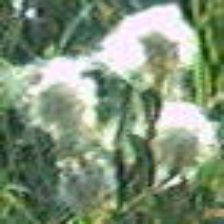

In [16]:
dl_train = create_dataloader(cfg, dat_train.crop_path, dat_train.label_id_bin)
dl_val = create_dataloader(cfg, dat_val.crop_path, dat_val.label_id_bin)
instance=next(iter(dl_train))
ims = [instance["image"][x] for x in range(len(instance["image"]))]
labs = [instance["label"][x] for x in range(len(instance["label"]))]
labs = [lookup.query(f'label_id == {x}').iloc[0,0] for x in [x.numpy() for x in labs]]
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

ims = [invTrans(ims[x]) for x in range(len(ims))]
Image.fromarray((255*numpy.transpose(ims[0].numpy(), (1,2,0))).astype(numpy.uint8))
ims_pil = [Image.fromarray((255*numpy.transpose(ims[x].numpy(), (1,2,0))).astype(numpy.uint8)) for x in range(len(ims))]
ims_pil[0]

In [17]:
def display_images(
    images, labs,
    columns=5, width=20, height=8, max_images=1000000, 
    label_wrap_length=50, label_font_size=30):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        title=textwrap.wrap(labs[i], label_wrap_length)
        title="\n".join(title)
        plt.title(title, fontsize=label_font_size); 

# display_images(ims_pil, labs)

In [27]:
state = torch.load(
            open(f"/home/Vale/Documents/cv4e/CV4E-2025/runs/{run_name}/best.pt", "rb"), map_location="cpu", 
            weights_only=True
        )
state["epoch"]

100

In [41]:
state["model"]

OrderedDict([('feature_extractor.conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
              

In [42]:
model = load_model(cfg, n_class-1)[0]

Starting new model


In [43]:
model.load_state_dict(state["model"])
# model

<All keys matched successfully>

In [44]:
preds = model(instance["image"])
preds

preds_id = list(preds.argmax(axis=1).numpy())
preds_id[0:10]
preds_labs = [lookup.at[x, 'label_group'] for x in preds_id]
preds_labs[0:10]
truth_preds_labs = ["T:" + x + " - " + "P:" + y for x, y in zip(labs, preds_labs)]
truth_preds_labs[0:10]

# display_images(ims_pil, truth_preds_labs, label_font_size=15)

['T:NONE - P:NONE',
 'T:NONE - P:NONE',
 'T:STAF - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE',
 'T:NONE - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE',
 'T:STAF - P:NONE',
 'T:NONE - P:NONE']

In [45]:
instance=next(iter(dl_val))
ims = [instance["image"][x] for x in range(len(instance["image"]))]
labs = [instance["label"][x] for x in range(len(instance["label"]))]
labs = [lookup.query(f'label_id == {x}').iloc[0,0] for x in [x.numpy() for x in labs]]
ims = [invTrans(ims[x]) for x in range(len(ims))]
ims_pil = [Image.fromarray((255*numpy.transpose(ims[x].numpy(), (1,2,0))).astype(numpy.uint8)) for x in range(len(ims))]
preds = model(instance["image"])
preds_id = list(preds.argmax(axis=1).numpy())
preds_labs = [lookup.at[x, 'label_group'] for x in preds_id]
true_preds_labs = ["T:" + x + " - " + "P:" + y for x, y in zip(labs, preds_labs)]

# display_images(ims_pil, true_preds_labs, label_font_size=15)

In [46]:
device = "cuda"
all_predictions = []
all_labels = []
model.eval()
model.to(device)
with torch.no_grad():
    for batch_n, batch in tqdm(enumerate(dl_train), total = len(dl_train)):
        # put data and labels on device
        data, labels = batch["image"].to(device), batch["label"].to(device)

        # forward pass
        all_predictions.extend(model(data).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 389/389 [00:58<00:00,  6.69it/s]


In [47]:
all_predictions

[array([1.708861], dtype=float32),
 array([-1.4207032], dtype=float32),
 array([-0.80748683], dtype=float32),
 array([4.010337], dtype=float32),
 array([-2.3320556], dtype=float32),
 array([2.5814853], dtype=float32),
 array([-3.4452243], dtype=float32),
 array([4.6476116], dtype=float32),
 array([-1.9330175], dtype=float32),
 array([-2.7975593], dtype=float32),
 array([-2.3929906], dtype=float32),
 array([-2.5446568], dtype=float32),
 array([-3.5632792], dtype=float32),
 array([-0.2680521], dtype=float32),
 array([-1.7062511], dtype=float32),
 array([-0.8083227], dtype=float32),
 array([1.0209736], dtype=float32),
 array([-1.5302275], dtype=float32),
 array([-4.0770187], dtype=float32),
 array([-1.8072768], dtype=float32),
 array([-3.5869117], dtype=float32),
 array([-2.7080035], dtype=float32),
 array([-3.9621768], dtype=float32),
 array([-3.6983194], dtype=float32),
 array([-2.8420672], dtype=float32),
 array([3.8716364], dtype=float32),
 array([-2.4100904], dtype=float32),
 array([

In [14]:
# softmax = torch.logit(torch.softmax(torch.tensor(all_predictions), dim =1))
# preds = pd.DataFrame(softmax, columns=lookup.label_group).assign(label_id=all_labels).merge(lookup).drop(["label_id", "size"], axis=1)
# preds.to_csv("../outputs/predictions.csv")

/tmp/ipykernel_439869/4126068266.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/torch/csrc/utils/tensor_new.cpp:278.)


In [59]:
preds = pd.DataFrame(all_predictions, columns=["score"]).assign(label_id=all_labels).merge(lookup).drop(["label_id", "size"], axis=1)
preds

,score,label_group,label_group_bin,label_id_bin
0,1.708861,STAF,NONE,0
1,-1.420703,NONE,NONE,0
2,-0.807487,NONE,NONE,0
3,4.010337,STAF,NONE,0
4,-2.332056,NONE,NONE,0
...,...,...,...,...
99421,3.125133,STAF,NONE,0
99422,-3.390705,NONE,NONE,0
99423,-1.837706,NONE,NONE,0
99424,-1.427985,NONE,NONE,0


In [60]:
preds.to_csv("../outputs/predictions.csv")